In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostRegressor
from lmfit import Model
from xgboost import XGBRegressor
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import neighbors
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import mutual_info_regression,f_regression
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
import umap
from sklearn.metrics import make_scorer

pl.style.use('seaborn')
pl.rc('font',family='Arial')

## Read in data

In [3]:
train_data = pd.read_csv("SubCh1_TrainingData.csv")
test_data = pd.read_csv("SubCh1_TestData.csv")

train_data['Timepoint'] = [1 if i == '24HR' else 0 for i in train_data['Timepoint']]
train_data['Treatment'] = [1 if i == 'DHA' else 0 for i in train_data['Treatment']]
train_data['BioRep'] = [int(i[-1]) for i in train_data['BioRep']]

genes = list(train_data.drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis=1).columns)

## Split into four data frames and combine into one

Each new df corresponds to a particular timepoint/treatment combination:

- A: 6hr untreated
- B: 24hr untreated
- C: 6hr treated
- D: 24hr treated

In [4]:
X_A = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_B = train_data[(train_data['Timepoint'] == 1)&(train_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_C = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_D = train_data[(train_data['Timepoint'] == 1)&(train_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)

Y = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 0)]['DHA_IC50']

# rename columns:
X_A.columns = ['A' + str(i) for i in range(1,5541)]
X_B.columns = ['B' + str(i) for i in range(1,5541)]
X_C.columns = ['C' + str(i) for i in range(1,5541)]
X_D.columns = ['D' + str(i) for i in range(1,5541)]

X_A = X_A.reset_index().drop(['index'],axis=1)
X_B = X_B.reset_index().drop(['index'],axis=1)
X_C = X_C.reset_index().drop(['index'],axis=1)
X_D = X_D.reset_index().drop(['index'],axis=1)

# combine data frames:
X = pd.concat([X_A,X_B,X_C,X_D], axis=1)
X.head(10)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,D5531,D5532,D5533,D5534,D5535,D5536,D5537,D5538,D5539,D5540
0,1.311350,-1.613464,-1.298663,-1.441343,-1.735923,0.173112,2.466366,1.383979,-0.115130,0.287468,...,0.210607,-0.540993,-3.674097,-1.652979,-2.255490,-4.554757,-0.381422,-1.415857,-4.121011,-2.486528
1,0.997722,-1.553994,-1.960600,-1.424590,0.023609,0.420973,1.128427,0.722659,1.878123,-0.065159,...,-0.447109,0.450649,-4.464408,-0.977954,-2.012559,-4.538550,-2.333890,-2.342496,-4.774197,-1.794568
2,0.389508,-2.139782,-0.584985,-1.085373,0.803247,0.766617,1.701689,0.926101,1.600687,0.435633,...,-0.070151,0.024133,-2.215227,-1.957654,-2.188635,-4.424748,-2.986927,-1.722201,-3.995680,-0.902979
3,0.348560,-1.562540,-0.586732,-0.834661,1.096979,0.121817,1.623373,-0.654405,0.221121,0.998601,...,-1.288305,0.806314,-3.733712,-1.990368,-1.633418,-5.533077,-3.283316,-2.104227,-5.767710,-2.177930
4,0.138276,-1.612280,-1.362990,-1.360318,0.488124,0.365410,0.739845,-0.654702,2.170263,0.630418,...,0.279816,0.115002,-1.305902,-0.679212,-2.099512,-5.955507,-0.920594,-1.626372,-4.422711,-1.408485
5,-0.332565,-1.280348,-0.817751,-0.480521,-0.098970,0.112246,0.773993,-0.969944,1.117705,0.872166,...,0.375290,1.113241,-4.016287,-1.327287,-2.375500,-4.379304,-2.752906,-1.939162,-3.500963,-0.796143
6,-1.140942,-0.460872,0.588564,-1.214647,1.210955,1.336895,-0.857090,-1.884711,-0.001943,1.320737,...,0.666558,-2.016912,-4.682891,-0.254524,-2.668047,-6.573239,-3.264155,-0.671344,-5.312867,-2.248219
7,0.426584,-1.118851,-0.938263,-1.442067,0.747063,0.268388,1.062841,0.494635,0.866481,0.501923,...,-1.793459,-0.116719,-4.535173,-0.537190,-2.472669,-6.261742,-3.134708,-1.969545,-5.157691,-2.637917
8,0.037085,-1.488644,-1.838770,-1.066493,-1.305085,0.059484,2.128986,-0.527511,1.616871,0.235093,...,-0.478144,0.125283,-5.360958,-2.386122,-1.886257,-6.127057,-3.231487,-2.349583,-4.977880,-1.047555
9,-0.037537,-1.495531,-1.801568,-0.526676,-1.831555,0.494413,1.286978,-1.589983,1.060466,0.836018,...,1.213397,-1.032989,-8.298501,-0.080207,-2.335635,-4.606785,-2.849864,-2.028372,-3.179649,-2.205214


## Univariate f-regression, using top k features

In [5]:
def drop_univ(X_orig, Y, features):
    X = StandardScaler().fit_transform(X_orig)
    X_uni = GenericUnivariateSelect(f_regression,'k_best', param=features).fit_transform(X, Y.values.ravel())
    X_uni = pd.DataFrame(data = X_uni)

    return X_uni

### Test on reshaped data frame, testing different numbers of features

In [195]:
threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []
cv = []
cv_spear = []

for j in np.arange(10,310,10):
    X_uni = drop_univ(X,Y,j)

    max_features = min(len(X_uni.columns),50)

    X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test) 
    
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_uni.columns))
    cv.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5)))
    cv_spear.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r))))
    

results_unif = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols,cv,cv_spear)),columns =['threshold', 'accuracy','mse','spearman','num_cols','cv','cv_spear']) 

In [81]:
X_uni.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-1.292943,2.016833,1.845393,3.028196,2.500009,3.398555,-1.832262,-2.797206,2.040974,2.315473,...,-0.887688,2.622818,0.456541,-0.558260,-0.267840,-2.729300,1.309034,2.028177,-0.264554,2.195769
1,-1.862115,0.876737,1.447845,0.363864,-0.143767,0.191846,-1.231272,-1.575531,1.227064,0.379158,...,-0.669492,-0.426987,-0.039873,0.492228,2.270057,0.798605,1.540293,1.145054,2.077086,-0.464697
2,-0.022030,-0.054085,0.512837,0.075053,-0.269357,0.341495,-0.120556,0.342170,-0.260822,0.917548,...,-0.112742,-1.120642,-1.732666,-0.914019,-2.002187,1.050166,0.048109,-1.267189,0.086802,-1.155420
3,1.311045,1.271229,0.269660,1.266081,0.892360,-0.471573,-0.541877,-1.122765,0.043002,0.700775,...,-2.106042,-0.413747,2.332550,1.953799,-0.809012,-0.875863,-1.292227,0.450239,-1.740346,-1.346451
4,0.698626,0.757369,0.098395,-0.270719,-0.766589,-1.095904,0.367818,0.453151,0.028027,-0.082555,...,1.082295,-1.792682,-0.798296,0.132350,1.037966,0.825620,0.869621,-0.424967,1.997906,0.614622


0.646732810299622


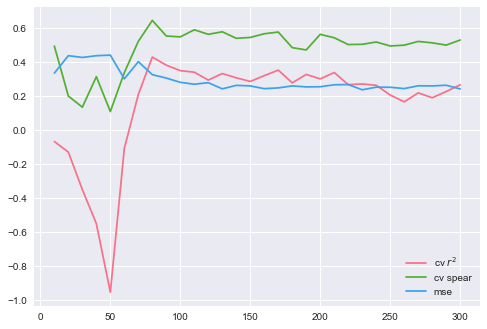

In [205]:
sns.set_palette("husl", 3)

print(np.max(results_unif['cv_spear']))

pl.plot(results_unif['threshold'],results_unif['cv'])
pl.plot(results_unif['threshold'],results_unif['cv_spear'])
pl.plot(results_unif['threshold'],results_unif['mse'])
pl.legend([r'cv $r^2$','cv spear','mse'])
pl.show()

## Test on only 24hr, treated data frame

In [193]:
threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []
cv = []
cv_spear = []

for j in np.arange(10,310,10):
    X_uni = drop_univ(X_D,Y,j)

    max_features = min(len(X_uni.columns),50)

    X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test) 
    
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_uni.columns))
    cv.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5)))
    cv_spear.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r))))
    

results_unif_sub = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols,cv,cv_spear)),columns =['threshold', 'accuracy','mse','spearman','num_cols','cv','cv_spear']) 

0.4747580444788545


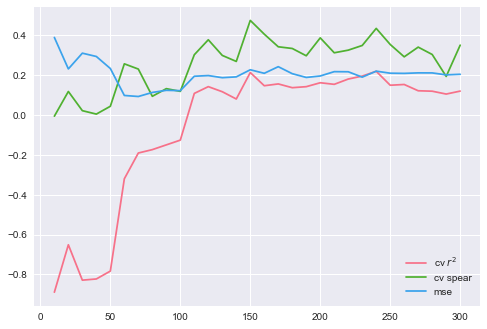

In [204]:
sns.set_palette("husl", 3)

print(np.max(results_unif_sub['cv_spear']))

pl.plot(results_unif_sub['threshold'],results_unif_sub['cv'])
pl.plot(results_unif_sub['threshold'],results_unif_sub['cv_spear'])
pl.plot(results_unif_sub['threshold'],results_unif_sub['mse'])
pl.legend([r'cv $r^2$','cv spear','mse'])
pl.show()

## Test on only 6hr, treated data frame

In [188]:
threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []
cv = []
cv_spear = []

for j in np.arange(10,310,10):
    X_uni = drop_univ(X_C,Y,j)

    max_features = min(len(X_uni.columns),50)

    X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test) 
    
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_uni.columns))
    cv.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5)))
    cv_spear.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r))))
    

results_unif_sub2 = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols,cv,cv_spear)),columns =['threshold', 'accuracy','mse','spearman','num_cols','cv','cv_spear']) 

0.5462275359521785


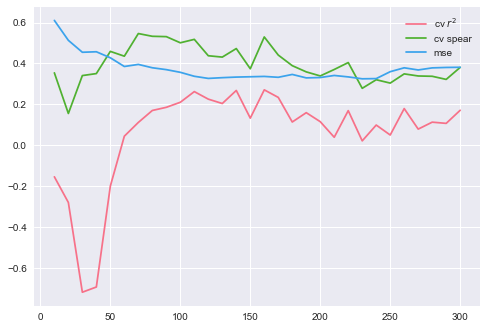

In [203]:
sns.set_palette("husl", 3)

print(np.max(results_unif_sub2['cv_spear']))

pl.plot(results_unif_sub2['threshold'],results_unif_sub2['cv'])
pl.plot(results_unif_sub2['threshold'],results_unif_sub2['cv_spear'])
pl.plot(results_unif_sub2['threshold'],results_unif_sub2['mse'])
pl.legend([r'cv $r^2$','cv spear','mse'])
pl.show()

In [6]:
X_s = StandardScaler().fit_transform(X)
transformer = GenericUnivariateSelect(f_regression,'k_best', param=200)
X_uni = transformer.fit_transform(X_s, Y.values.ravel())
X_uni = pd.DataFrame(data = X_uni)

indices = transformer.get_support(indices=False)

X_features = X.columns[indices].tolist()

In [7]:
print(X_features)

['A1040', 'A1184', 'A1605', 'A2793', 'A3860', 'A4817', 'A5060', 'B60', 'B132', 'B506', 'B578', 'B945', 'B1736', 'B1827', 'B2431', 'B4030', 'B5482', 'C34', 'C44', 'C45', 'C247', 'C285', 'C308', 'C365', 'C385', 'C396', 'C403', 'C419', 'C426', 'C443', 'C511', 'C521', 'C563', 'C579', 'C612', 'C696', 'C702', 'C717', 'C766', 'C814', 'C827', 'C858', 'C872', 'C894', 'C908', 'C987', 'C1009', 'C1021', 'C1032', 'C1046', 'C1084', 'C1103', 'C1122', 'C1148', 'C1150', 'C1240', 'C1261', 'C1288', 'C1315', 'C1374', 'C1422', 'C1428', 'C1490', 'C1503', 'C1531', 'C1559', 'C1571', 'C1595', 'C1636', 'C1662', 'C1702', 'C1711', 'C1717', 'C1751', 'C1786', 'C1820', 'C1895', 'C1904', 'C1949', 'C1970', 'C1990', 'C2035', 'C2097', 'C2260', 'C2287', 'C2297', 'C2344', 'C2355', 'C2444', 'C2534', 'C2567', 'C2580', 'C2610', 'C2681', 'C2711', 'C2714', 'C2718', 'C2875', 'C2905', 'C2915', 'C2931', 'C2979', 'C3026', 'C3078', 'C3090', 'C3131', 'C3195', 'C3238', 'C3256', 'C3257', 'C3291', 'C3294', 'C3319', 'C3324', 'C3357', 'C

In [124]:
X_s = StandardScaler().fit_transform(X_D)
transformer = GenericUnivariateSelect(f_regression,'k_best', param=70)
X_uni = transformer.fit_transform(X_s, Y.values.ravel())
X_uni = pd.DataFrame(data = X_uni)

indices = transformer.get_support(indices=False)

X_D_features = X_D.columns[indices].tolist()

In [125]:
print(X_D_features)

['D2', 'D10', 'D14', 'D178', 'D206', 'D252', 'D292', 'D321', 'D410', 'D879', 'D960', 'D1035', 'D1056', 'D1103', 'D1107', 'D1108', 'D1110', 'D1181', 'D1314', 'D1367', 'D1459', 'D1505', 'D1553', 'D1603', 'D1626', 'D1901', 'D1910', 'D1914', 'D1985', 'D2061', 'D2229', 'D2233', 'D2236', 'D2241', 'D2279', 'D2342', 'D2619', 'D2643', 'D2753', 'D3069', 'D3169', 'D3349', 'D3398', 'D3432', 'D3463', 'D3464', 'D3564', 'D3638', 'D3647', 'D3924', 'D4062', 'D4161', 'D4193', 'D4227', 'D4447', 'D4591', 'D4640', 'D4754', 'D4785', 'D4815', 'D4866', 'D4995', 'D5025', 'D5029', 'D5033', 'D5182', 'D5183', 'D5481', 'D5485', 'D5520']


In [126]:
X_s = StandardScaler().fit_transform(X_C)
transformer = GenericUnivariateSelect(f_regression,'k_best', param=70)
X_uni = transformer.fit_transform(X_s, Y.values.ravel())
X_uni = pd.DataFrame(data = X_uni)

indices = transformer.get_support(indices=False)

X_C_features = X_C.columns[indices].tolist()

In [127]:
print(X_C_features)

['C44', 'C365', 'C396', 'C419', 'C426', 'C511', 'C563', 'C766', 'C1009', 'C1021', 'C1103', 'C1240', 'C1315', 'C1422', 'C1531', 'C1559', 'C1702', 'C1717', 'C1751', 'C1786', 'C1820', 'C1904', 'C1949', 'C1970', 'C2035', 'C2097', 'C2260', 'C2287', 'C2444', 'C2567', 'C2681', 'C2711', 'C2714', 'C2718', 'C2875', 'C2905', 'C2931', 'C3078', 'C3195', 'C3238', 'C3257', 'C3291', 'C3357', 'C3361', 'C3436', 'C3531', 'C3577', 'C3654', 'C3702', 'C3739', 'C3985', 'C4101', 'C4292', 'C4440', 'C4607', 'C4743', 'C4792', 'C4861', 'C4982', 'C4983', 'C4987', 'C4988', 'C5000', 'C5019', 'C5024', 'C5058', 'C5240', 'C5245', 'C5444', 'C5465']


In [129]:
list(set(X_features) & set(X_D_features))

['D5520',
 'D4447',
 'D1901',
 'D178',
 'D2241',
 'D2061',
 'D5025',
 'D1103',
 'D5183',
 'D1107',
 'D4866',
 'D960',
 'D1181']

### Conclusion: treated 24hr gives better Spearman score, but reshaped gives better cross-val score
- Weirdly, more features from the 6hr treated timepoint were used in the reshaped version

## Randomized search with Random Forest and reshaped data frame

In [136]:
def spear_r(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]

In [235]:
X_s = StandardScaler().fit_transform(X)
transformer = GenericUnivariateSelect(f_regression,'k_best', param=70)
X_uni = transformer.fit_transform(X_s, Y.values.ravel())
X_uni = pd.DataFrame(data = X_uni)

In [167]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

forest_model = RandomForestRegressor(bootstrap=False)

param_dist = {"n_estimators": sp_randint(100,200),
              "max_features": sp_randint(20, 70),
              "max_depth": sp_randint(10,300)}

scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse': make_scorer(mean_squared_error)}

n_iter_search = 100
random_search = RandomizedSearchCV(forest_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, 
                                   scoring = scoring, refit = 'spear_r', return_train_score=True)

random_search.fit(X_train, Y_train.values.ravel())
print(random_search.best_params_)

scores = pd.DataFrame(random_search.cv_results_)
condition = scores['rank_test_spear_r'] == 1
df_1 = scores[condition].reset_index(drop = True)
df_1.loc[0, 'mean_test_spear_r']

{'max_depth': 111, 'n_estimators': 153, 'max_features': 41}


0.5783716130081855

In [173]:
scores[['param_max_depth','param_max_features','param_n_estimators','rank_test_spear_r']].sort_values(by='rank_test_spear_r').head(10)

,param_max_depth,param_max_features,param_n_estimators,rank_test_spear_r
91,111,41,153,1
93,73,37,110,2
15,289,48,122,3
97,136,33,149,4
32,222,29,158,5
62,157,25,195,6
38,292,32,130,7
95,254,21,168,8
78,217,38,121,9
92,78,44,151,10


## Grid Search

In [227]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

forest_model = RandomForestRegressor(bootstrap=False)

param_grid = {"n_estimators": np.arange(70,150,2),
              "max_features": np.arange(5,40,1)}

scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse': make_scorer(mean_squared_error)}

grid_search = GridSearchCV(forest_model, param_grid=param_grid, cv=5, iid=False, 
                                   scoring = scoring, refit = 'spear_r', return_train_score=True)

grid_search.fit(X_train, Y_train.values.ravel())
print(grid_search.best_params_)

grid_scores = pd.DataFrame(grid_search.cv_results_)
condition = grid_scores['rank_test_spear_r'] == 1
df_2 = grid_scores[condition].reset_index(drop = True)
df_2.loc[0, 'mean_test_spear_r']

{'n_estimators': 138, 'max_features': 15}


0.609701341464614

In [236]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

forest_model = RandomForestRegressor(max_features=15,n_estimators=138, bootstrap=False,random_state = 999)
forest_model.fit(X_train, Y_train.values.ravel())
Y_pred = forest_model.predict(X_test) 

print('accuracy: ' + str(forest_model.score(X_test,Y_test)))
print('mse: ' + str(mean_squared_error(Y_test, Y_pred)))
print('spearman: ' + str(spearmanr(Y_test,Y_pred)[0]))
print('cv score: ' + str(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5))))
print('cv spear: ' + str(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r)))))

accuracy: 0.07202779079823896
mse: 0.23685206915748866
spearman: 0.31680904720510966
cv score: 0.3118086687916939
cv spear: 0.5080494489071191


In [242]:
importances = list(forest_model.feature_importances_)
feature_list = X_features
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('{:20} Importance: {}'.format(*pair)) for pair in feature_importances];

C3436                Importance: 0.16
C4988                Importance: 0.07
C2711                Importance: 0.05
C2714                Importance: 0.04
B506                 Importance: 0.03
C2035                Importance: 0.03
C3985                Importance: 0.03
D5183                Importance: 0.03
A1040                Importance: 0.02
B1736                Importance: 0.02
C1751                Importance: 0.02
C2931                Importance: 0.02
C3238                Importance: 0.02
C3257                Importance: 0.02
C3531                Importance: 0.02
D1107                Importance: 0.02
D1181                Importance: 0.02
D1901                Importance: 0.02
D5025                Importance: 0.02
D5520                Importance: 0.02
A2793                Importance: 0.01
B2431                Importance: 0.01
B4030                Importance: 0.01
C396                 Importance: 0.01
C419                 Importance: 0.01
C1103                Importance: 0.01
C1315       

In [249]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

forest_model = RandomForestRegressor(bootstrap=False)

param_grid = {"n_estimators": np.arange(70,150,2),
              "max_features": np.arange(5,40,1)}

scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse': make_scorer(mean_squared_error)}

grid_search = GridSearchCV(forest_model, param_grid=param_grid, cv=5, iid=False, 
                                   scoring = scoring, refit = 'r2', return_train_score=True)

grid_search.fit(X_train, Y_train.values.ravel())
print(grid_search.best_params_)

grid_scores = pd.DataFrame(grid_search.cv_results_)
condition = grid_scores['rank_test_spear_r'] == 1
df_2 = grid_scores[condition].reset_index(drop = True)
df_2.loc[0, 'mean_test_spear_r']

{'n_estimators': 76, 'max_features': 15}


0.6183434831142547

In [250]:
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

forest_model = RandomForestRegressor(max_features=15,n_estimators=76, bootstrap=False,random_state = 999)
forest_model.fit(X_train, Y_train.values.ravel())
Y_pred = forest_model.predict(X_test) 

print('mse: ' + str(mean_squared_error(Y_test, Y_pred)))
print('accuracy: ' + str(forest_model.score(X_test,Y_test)))
print('spearman: ' + str(spearmanr(Y_test,Y_pred)[0]))
print('cv score: ' + str(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5))))
print('cv spear: ' + str(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r)))))

mse: 0.2325566657577832
accuracy: 0.08885692383649435
spearman: 0.3133385255612352
cv score: 0.305851220228318
cv spear: 0.5348005052555781


## UMAP tests

In [244]:
X_new = umap.UMAP().fit_transform(X_uni)
X_new = pd.DataFrame(data=X_new)
X_df = pd.concat([X_new.reset_index().drop(['index'],axis=1),Y.reset_index().drop(['index'],axis=1)], axis=1)

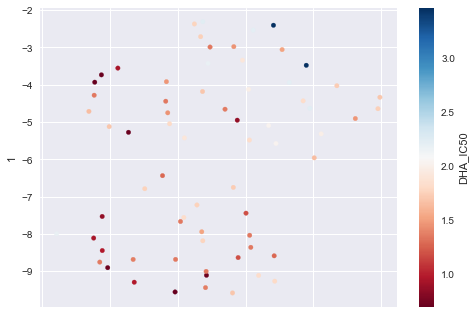

In [247]:
X_df.plot.scatter(x=0,y=1,c='DHA_IC50',colormap='RdBu')
pl.show()